In [1]:
import sys, os, time, numpy as np, matplotlib.pyplot as plt
# from matplotlib.colors import ListedColormap, LinearSegmentedColormap
# from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

In [2]:
def focus_phasemap_builder(points, focal_point_coords, k, focal_point_phase = 0):

    """
    Builds a phasemap for an AMM or PAT creating a focus at some point in 3D space.

    args:
        points: matrix describing the postitions of elements on the AMM or PAT surface.
        focal_point_coords: (x, y, z) coords of the focus.
        k: wavenumber
        
    returns:
        norm_phase_array: matrix of phase delays from -pi to pi, with the same size as AMM_points, describing the
        phase delays to build a focus at focal_point_coords.

    """

    travel_distance_array = [] # matrix of distances from centre of each elem to focus
    
    for elem_coord in points:
        travel_distance_array.append(np.sqrt((elem_coord[0] + focal_point_coords[0])**2 + \
                                             (elem_coord[1] + focal_point_coords[1])**2 + \
                                             (elem_coord[2] + focal_point_coords[2])**2))

    # total change in phase of waves as they travel this distance.
    total_phase_array = focal_point_phase - np.array(travel_distance_array) * k 

    # normalise between 0 and 2π [rads].
    norm_phase_array = np.remainder(total_phase_array, 2*np.pi) - np.pi
    
    return norm_phase_array


def points_vector_builder(centrepoint, extents, pixel_spacing):
    
    """
    
    We can define an evalution plane using 3 inputs:

    args:
        centrepoint: (x, y, z) tuple describing the central point of the evaulation plane (meters).
        extents: list of tuples in the form [(+x, -x), (+y, -y), (+z, -z)] describing the distances which the plane
        extends in each +ve and -ve direction from the centrepoint. In order to create a valid 2D plane, one of
        (+x, -x), (+y, -y), or (+z, -z) must be (0, 0).
        pixel_spacing: distance between pixels on the evaluation plane (meters).
    
    returns:
        points_vector_list: list of x, y and z coordinate arrays.
    
    """

    # side vectors for evaluation point matrix
    x = np.arange(centrepoint[0] - (extents[0][0]) + (pixel_spacing/2),
                  centrepoint[0] + (extents[0][1]),
                  pixel_spacing)
    
    y = np.arange(centrepoint[1] - (extents[1][0]) + (pixel_spacing/2),
                  centrepoint[1] + (extents[1][1]),
                  pixel_spacing)
    
    z = np.arange(centrepoint[2] - (extents[2][0]) + (pixel_spacing/2),
                  centrepoint[2] + (extents[2][1]),
                  pixel_spacing)
    
    # if yz plane
    if extents[0] == (0, 0): 
        yy, zz = np.meshgrid(y, z)
        xx = centrepoint[0]*np.ones(len(y)*len(z))
    
    # if xz plane
    elif extents[1] == (0, 0): 
        xx, zz = np.meshgrid(x, z)
        yy = centrepoint[1]*np.ones(len(x)*len(z))
        
    # if xy plane    
    elif extents[2] == (0, 0):
        xx, yy = np.meshgrid(x, y)
        zz = centrepoint[2]*np.ones(len(x)*len(y))
    
    # return a list of x, y and z vectors
    
    return np.concatenate((xx.reshape(1, -1), yy.reshape(1, -1), zz.reshape(1, -1))).T


def GF_propagator_function_builder(reflector_points, eval_points, normals, areas, k):
    
    """
    
    http://www.personal.reading.ac.uk/~sms03snc/fe_bem_notes_sncw.pdf
    
    builds a scattering matrix for the sound propagation of a set elements/sources that cover
    a finite area in which they are assumed to have a constant pressure.

    args:
        reflector_points: matrix of x,y,z coords for the reflecting elements.
        eval_points: matrix of evaluation x,y,z coords at the propagation plane.
        normals: for a flat metasurface you get n*m times the vector [0, 0, 1].
        area: vector of the areas covered by each element (1, n*m).
        k: wavenumber.
        

    returns:
        H: Gives distance matrix of all distances between reflector and evaluation points (n*m, p*q).
        
    """
    # assign variables for x, y and z coord vectors for reflectors, evaluation points and normals
    rp_x, rp_y, rp_z = reflector_points.T
    ep_x, ep_y, ep_z = eval_points.T
    nm_x, nm_y, nm_z = normals
    
    # compute distances between eval_points and reflecting elements
    r = np.sqrt((rp_x.reshape(-1, 1) - ep_x.reshape(1, -1))**2 + \
                (rp_y.reshape(-1, 1) - ep_y.reshape(1, -1))**2 + \
                (rp_z.reshape(-1, 1) - ep_z.reshape(1, -1))**2)
    
    # partial of greens w.r.t normals
    g = -(1/(4*np.pi)) * np.exp(1j*k*r) * (1j*k*r-1)/(r**3)
    
    # find infinities and set them to zero.
    g[g == np.inf] = 0 
    
    # equation 2.21 in the pdf
    g = g * ((ep_x.reshape(1, -1) - rp_x.reshape(-1, 1)) * nm_x.T + \
             (ep_y.reshape(1, -1) - rp_y.reshape(-1, 1)) * nm_y.T + \
             (ep_z.reshape(1, -1) - rp_z.reshape(-1, 1)) * nm_z.T)
    
    # include reflector areas to build propagator function H
    H = g * areas.T
    
    return H


def GF_prop(AMM_surface_pressure, H, prop_direction):
    
    """
    
    find the product of the propagator, H, and AMM surface pressure to find pressure at evaluation plane.
    
    args:
        AMM_surface_pressure: complex pressure matrix on AMM surface.
        H: the propagator function defined using "GF_propagator_function_builder" 
        prop_direction: direction of propagation ("forward" or "backward").
        
    returns:
        complex pressure matrix at the evaluation plane.
    
    """
    
    # forward propagate from AMM plane to evaluation plane
    if prop_direction == "forward":
        return 2 * np.dot(AMM_surface_pressure, H) 
    
    # backward propagate from evaluation plane to AMM
    elif prop_direction == "backward":
        return 2 * np.dot(AMM_surface_pressure, np.conj(H).T) 
    
    else:
        print(prop_direction, "is not a valid propagation direction, please specifiy either 'forward' or 'backward'.")

In [3]:
# ---> physics params <---
c0 = 343.  # [m/s]
v = 40000  # [Hz]
lam = c0 / v  # [m]
k = 2 * np.pi / lam  # [rads/m]
resolution = 4

In [12]:
# ----> AMM plane <----
m_AMM, n_AMM = 16, 16
dx_AMM = lam/2 # cell spacing [m]
AMM_centrepoint = (0, 0, 0)
AMM_sidelengths = [((m_AMM/2)*dx_AMM, (m_AMM/2)*dx_AMM),
                   ((n_AMM/2)*dx_AMM, (n_AMM/2)*dx_AMM),
                   (0, 0)]
AMM_points = points_vector_builder(AMM_centrepoint, AMM_sidelengths, dx_AMM)

# ----> normals & areas <----
AMM_normals = [np.zeros((1, n_AMM*m_AMM)), np.zeros((1, n_AMM*m_AMM)), np.ones((1, n_AMM*m_AMM))]
AMM_areas = (dx_AMM**2)*np.ones((1, n_AMM*m_AMM))

back prop shape: (256, 1)


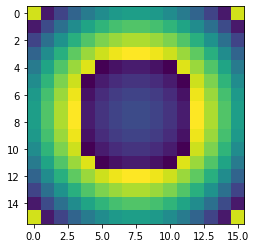

In [14]:
eval_points = np.array([0, 0, 10*lam])

H = GF_propagator_function_builder(AMM_points, eval_points, AMM_normals, AMM_areas, k)

back_prop = 2 * np.dot(np.exp(1j*np.pi), np.conj(H))
print("back prop shape:", back_prop.shape)

back_prop = back_prop.reshape(m_AMM, n_AMM)

plt.imshow(np.angle(back_prop))
plt.show()

In [5]:
# ----> xy eval planes <----
m_xy_eval, n_xy_eval = m_AMM*resolution, n_AMM*resolution
dx_xy_eval = dx_AMM/resolution
xy_eval_sidelengths = [(m_AMM/4*lam, m_AMM/4*lam),
                       (n_AMM/4*lam, n_AMM/4*lam),
                       (0, 0)] # [(-x, +x), (-y, +y), (-z, +z)]

focus_coords_list = [[ 0    , 0    , 10*lam],
                     [ 2*lam, 2*lam, 10*lam],
                     [-2*lam, 2*lam, 10*lam],
                     [ 2*lam,-2*lam, 10*lam],
                     [-2*lam,-2*lam, 10*lam]]

xy_eval_points_list = []
for focus_coords in focus_coords_list:
    xy_eval_points_list.append(points_vector_builder(focus_coords, xy_eval_sidelengths, dx_xy_eval))

In [6]:
xy_propagations_list = []
phasemap_list = []

for i, focus_coords in enumerate(focus_coords_list):
    
    # phasemaps
    phasemap_vec = focus_phasemap_builder(AMM_points, focus_coords, k)
    phasemap_list.append(phasemap_vec.reshape(m_AMM, n_AMM))
    surface_pressure = np.ones_like(phasemap_vec)*np.exp(1j*phasemap_vec)

    # pressure maps
    xy_H = GF_propagator_function_builder(AMM_points, xy_eval_points_list[i], AMM_normals, AMM_areas, k)
    xy_propagation = GF_prop(surface_pressure, xy_H, "forward").reshape(m_xy_eval, n_xy_eval)
    xy_propagations_list.append(xy_propagation)

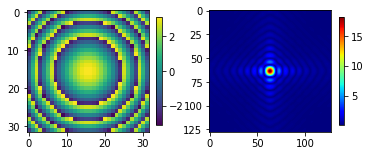

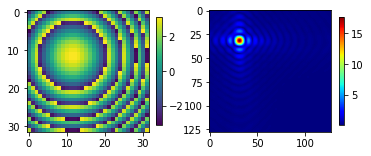

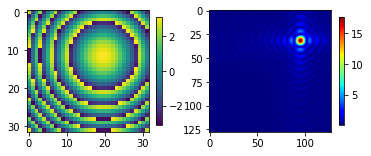

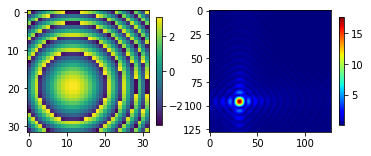

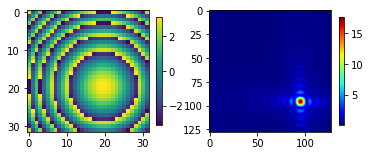

In [7]:
for i in range(len(xy_propagations_list)):

    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    im1 = ax1.imshow(phasemap_list[i], vmin=-np.pi, vmax=np.pi)
    fig.colorbar(im1, ax=ax1, shrink=0.5)
    
    im2 = ax2.imshow(abs(xy_propagations_list[i]), cmap=plt.get_cmap("jet"))
    fig.colorbar(im2, ax=ax2, shrink=0.5)
    
    plt.show()